TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal, entropy

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
from waveimage import calc_U

In [10]:
DECODER = 'base'
#DECODER = 'base' 
if DECODER == 'base':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
elif DECODER == 'naive':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-naive.pkl", "rb"))
elif DECODER == 'naive-test':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
#mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-noisy-alt.pkl", "rb"))

In [ ]:
ENCODER = 'base'
#ENCODER = 'backbone-CNN-parts' 
if ENCODER == 'backbone-CNN-parts':
    import backbone_CNN_parts_def
    file_name = "models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts"
    saver.restore(sess,       file_name + ".ckpt")
    mem    = pickle.load(open(file_name + "_mem.pkl", "rb"))

## Creation de la base d'apprentissage

In [11]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [12]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [13]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [14]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [15]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [16]:
DEPTH_WAV = 3
NB_LABEL = 10

In [17]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u] + 1e-10 * np.eye(3))
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [18]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik_naive(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        '''if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:'''
        if h == 0:
            dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
        else:
            dist = multivariate_normal(mean = mu[c][h][u], cov = np.diag(Sigma[c][h][u] + 1e-10))
            #lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
            lik[c] =  dist.pdf(v)
        '''else:
            lik[c] = 0'''
        lik[c] = max(lik[c], 1e-16)    
    return lik

In [19]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [20]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

# Parcours predictif

In [21]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [22]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [23]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [24]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [25]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [26]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [27]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [28]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    

In [29]:
DECODER

'base'

h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            if MODEL == 'base':
                lik = calc_lik(v_predictive, h, u)
            elif MODEL == 'naive':
                lik = calc_lik_naive(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

In [30]:
h_max = 6
if DECODER == 'base':
    lik_predictive_base = {}
elif DECODER == 'naive' or DECODER == 'naive-test':  
    lik_predictive_naive = {}
for c in range(10):
    if DECODER == 'base':
        lik_predictive_base[c] = {}
    elif DECODER == 'naive' or DECODER == 'naive-test':  
        lik_predictive_naive[c] = {}
    for h in range(h_max):
        if DECODER == 'base':
            lik_predictive_base[c][h] = {}
        elif DECODER == 'naive' or DECODER == 'naive-test':  
            lik_predictive_naive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            if DECODER == 'base':
                lik = calc_lik(v_predictive, h, u)
                lik_predictive_base[c][h][u] = lik
            elif DECODER == 'naive' or DECODER == 'naive-test':
                lik = calc_lik_naive(v_predictive, h, u)
                lik_predictive_naive[c][h][u] = lik

In [121]:
def predictive_search(z_ref, log_score, actions_set, mem_h_u, FLAG_POL = 'sharp-predictive-Info-Gain'):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    #print batch_size
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        log_score_path[i] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                log_score_path[i] = update_log_score(log_score_path[i], lik_predictive[z_ref][h_path][u_path])
        #print log_score_path[i]
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, u_gen in enumerate(actions_set):
        if FLAG_POL != 'sharp-predictive-Info-Gain':
            q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i])) 
            if FLAG_POL == 'sharp-predictive-Infomax':
                FEP_post[i] = entropy(q_post)
            elif FLAG_POL == 'sharp-predictive-Innovation':
                FEP_post[i] = - entropy(q_post, q_pre)
            elif FLAG_POL == 'sharp-predictive-Conservation':
                FEP_post[i] = - np.log(q_post[z_ref])
            elif FLAG_POL == 'sharp-predictive-IG-post':
                delta_log_score_path = log_score_path[i] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                FEP_post[i] = entropy(q_post) + entropy(q_post, delta_q_post )    
        else: # FLAG_POL == 'sharp-predictive-Info-Gain'
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            FEP_post[i] = - np.log(delta_q_post[z_ref])
        if not np.isfinite(FEP_post[i]):
            print "aie!!"
            FEP_post[i] = 50
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    #print log_score_path[i_min] 
    #print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [123]:
def FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_POL = 'smooth-predictive-Info-Gain'):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(actions_set)
    batch_size = batch_ref * NB_LABEL
    log_score_path = {}
    
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            log_score_path[i_full] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                for c in range(NB_LABEL):
                    i_full = c * batch_ref + i
                    log_score_path[i_full] = update_log_score(log_score_path[i_full],\
                                                              lik_predictive[c][h_path][u_path])
                        
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    '''log_score_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        log_score_post_full += q_pre[c] * log_score_path[i_full]    #print q_pre'''
        
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            if FLAG_POL != 'smooth-predictive-Info-Gain':
                q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
                if FLAG_POL == 'smooth-predictive-Infomax':
                    FEP_post[i_full] = entropy(q_post)
                elif FLAG_POL == 'smooth-predictive-Innovation':
                    FEP_post[i_full] = - entropy(q_post, q_pre)
                elif FLAG_POL == 'smooth-predictive-Conservation':
                    FEP_post[i_full] = - np.log(q_post[c])
                elif FLAG_POL == 'smooth-predictive-IG-post':
                    delta_log_score_path = log_score_path[i_full] - log_score[0]
                    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                    FEP_post[i_full] = entropy(q_post) + entropy(q_post, delta_q_post )    
            else: # FLAG_POL == 'smooth-predictive-Info-Gain'
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                FEP_post[i_full] = - np.log(delta_q_post[c])
            if not np.isfinite(FEP_post[i_full]):
                print "aie!!"
                FEP_post[i_full] = 50
                
    #ch = raw_input('')    
    FEP_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        FEP_post_full += q_pre[c] * FEP_post[c * batch_ref : (c + 1) * batch_ref]
        #print FEP_post[c * batch_ref : (c + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    #print FEP_post_full
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    #print i_min, dict_u[i_min], FEP_post_full[i_min]
    ## 3 ##
    return dict_u[i_min]  #pi_path[i_max][z_ref]
    

In [114]:
def prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_POL = 'sharp-predictive-Info-Gain'):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde = predictive_search(z_tilde, log_score, actions_set, mem_h_u, FLAG_POL)
    
    return u_tilde

In [115]:
def FEP_prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_POL = 'smooth-predictive-Info-Gain'):
    
    u_tilde = FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_POL)
    
    return u_tilde

In [116]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [117]:
def generic_saliency_based_policy(H_predictive_sorted, mem_h_u):
    u_tilde = H_predictive_sorted.pop()[1]
    return u_tilde

In [118]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [127]:
def scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4, INIT = 'limit'):
    
    assert POL == 'sharp-predictive-Info-Gain' or POL == 'sharp-predictive-Infomax'\
    or POL == 'sharp-predictive-Innovation' or POL == 'sharp-predictive-Innovation' or POL == 'sharp-predictive-IG-post'\
    or POL == 'saliency-based' or POL == 'random' or POL == 'full' or POL == 'generic-saliency-based'\
    or POL == 'smooth-predictive-Info-Gain' or POL == 'smooth-predictive-Infomax'\
    or POL == 'smooth-predictive-Innovation' or POL == 'smooth-predictive-Innovation' or POL == 'smooth-predictive-IG-post'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'generic-saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    if True : #POL == 'generic-saliency-based':
        H_predictive_sorted = calc_H_predictive_sorted(H_generic_eff)     
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if TOUR == 0 and INIT == 'H0-init':
            u_tilde = H_predictive_sorted[-1][1]
        else:
            if POL == 'sharp-predictive-Info-Gain' or POL == 'sharp-predictive-Infomax'\
            or POL == 'sharp-predictive-Innovation' or POL == 'sharp-predictive-Innovation' or POL == 'sharp-predictive-IG-post':
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_POL = POL)
            elif POL == 'smooth-predictive-Info-Gain' or POL == 'smooth-predictive-Infomax'\
              or POL == 'smooth-predictive-Innovation' or POL == 'smooth-predictive-Innovation' or POL == 'smooth-predictive-IG-post':
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_POL = POL)
            elif POL == 'saliency-based' :
                u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
            elif POL == 'generic-saliency-based':
                u_tilde = generic_saliency_based_policy(H_predictive_sorted, mem_h_u)
            else:
                u_tilde = random_policy(log_score, mem_h_u)
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                lik = calc_lik(v, h_path, u_path)
                log_score[0] = update_log_score(log_score[0], lik)
                #wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3  
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [39]:
from record import Record, affiche_records            

In [124]:
NB_TRIALS = 1000

In [125]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


    Policy : predictive, threshold : 0.03, 4 saccades, initial : 3, final : 7, classe : 7, elapsed time : 4.96038
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 0, final : 2, classe : 2, elapsed time : 9.72888
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 11.6165
    Policy : predictive, threshold : 0.03, 2 saccades, initial : 0, final : 0, classe : 0, elapsed time : 14.5421
    Policy : predictive, threshold : 0.03, 8 saccades, initial : 4, final : 4, classe : 4, elapsed time : 22.9571
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 24.8637
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 7, final : 4, classe : 4, elapsed time : 28.7859
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 8, final : 9, classe : 9, elapsed time : 33.8153
    Policy : predictive, threshold : 0.03, 10 saccades, initial : 2, final : 5, classe : 5, elapsed time : 44.5951
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 0, final : 9, classe : 9, elapsed time : 48.4158

In [42]:
# Test generic saliency map

In [ ]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
#file_name = "mnist-waveimage-records-FEP-dual-full-H0_init-IMOL-9.npy" #random.npy" #-naive-bayes.npy"
#file_name = "mnist-waveimage-records-FEP-dual-full-naive-bayes.npy"
file_name = "tmp"
INIT = 'H0-init' #

if DECODER == 'base':
    lik_predictive = lik_predictive_base
elif DECODER == 'naive' or DECODER == 'naive-test':
    lik_predictive = lik_predictive_naive

liste_pol  = ('smooth-predictive-Info-Gain', 'smooth-predictive-Infomax', \
    'smooth-predictive-Innovation', 'smooth-predictive-Innovation', 'smooth-predictive-IG-post', \
    'sharp-predictive-Info-Gain', 'sharp-predictive-Infomax', \
    'sharp-predictive-Innovation', 'sharp-predictive-Innovation', 'sharp-predictive-IG-post', \
    'saliency-based', 'generic-saliency-based', 'random', 'full')
    
if True : #not os.path.isfile(file_name):
    # IMOL change 
    # FEP-predictive-KL : PUC
    # FEP-predictive-dual : -PEC
    # FEP-predictive : Infomax
    for POL in liste_pol:
        dict_records[POL] = {}

        for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        #for THRESHOLD in (2, 1.5, 1, 7e-1, 5e-1, 3e-1, 2e-1, 1e-1):# 
        #for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2): #, 1e-5):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                #m_test = np.sum(x_test) 
                #x_noise =  x_test * .9  + .1 * ((1 - x_test) * np.random.rand(28 * 28))
                #x_noise = x_test * .9  + .1 * ((1 - x_test))
                #x_dim = x_test * .5
                #x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #x_noise = x_noise * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #m_noise = np.sum(x_noise)
                # x_noise = x_noise * m_test / m_noise
                x_noise = np.copy(x_test)
                '''for _ in range(75):
                    i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
                '''m_x = np.mean(x_test)
                x_noise = x_test * (1 - .4)  + .4 * (1 - x_test)
                x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise)'''# + 0.1 * np.random.randn(28 * 28)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_noise , (1, 28*28)))
                          # 
                # initial
                log_score = np.zeros((1,10))
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                z_tilde = -1

                # global coef --> log_score initial
                '''mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                h, u = 0, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                h, u = 1, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                pi = calc_pi(log_score)
                H = entropy(pi) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(log_score)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1'''
                mem_h_u = []

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1
                
                if ind_test == 0:
                    AFF = True
                else:
                    AFF = False

                z_final = scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = AFF, INIT = INIT, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                if NB_TRIALS <= 1000:
                    print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('smooth-predictive-IG-post', 0.1, 0)
************************************
******       TOUR    1        ******
************************************
CHOIX : (7, 8)
pi :  [  5.86787269e-04   2.26842914e-14   3.58102814e-04   3.43008662e-05
   7.77923690e-04   5.41083786e-06   1.35448967e-06   8.90530104e-01
   1.16578847e-04   1.07589437e-01]
out : 7
pi[out] :  0.890530104076
H :  0.357379116335
**** z : 7 , u : (7, 8)  --->  7
************************************
******       TOUR    2        ******
************************************
CHOIX : (9, 6)
pi :  [  6.01351801e-07   2.13608713e-25   2.27797309e-09   1.14956787e-06
   1.15864464e-12   1.42282046e-07   2.52515395e-24   9.99978462e-01
   6.11275539e-11   1.96424806e-05]
out : 7
pi[out] :  0.999978461977
H :  0.000261044771
**** z : 7 , u : (9, 6)  --->  7
************************************
******         FINI          *******
************************************
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, 

Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 16.4739
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 16.6789
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 16.8823
('smooth-predictive-IG-post', 0.1, 60)
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 16.9032
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 17.1102
Policy : smooth-predictive-IG-post, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 17.8359
Policy : smooth-predictive-IG-post, threshold : 0.1, 5 saccades, initial : -1, final : 2, classe : 3, elapsed time : 18.5852
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final :

Policy : smooth-predictive-IG-post, threshold : 0.1, 10 saccades, initial : -1, final : 6, classe : 4, elapsed time : 41.6229
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 41.8219
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 42.0387
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 42.0579
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 42.4529
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 42.6696
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 42.8881
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 43.3038

Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 64.6443
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 65.0518
Policy : smooth-predictive-IG-post, threshold : 0.1, 7 saccades, initial : -1, final : 8, classe : 5, elapsed time : 66.1788
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 66.1933
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 66.2119
('smooth-predictive-IG-post', 0.1, 190)
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 66.4298
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 66.6391
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final 

Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 86.419
('smooth-predictive-IG-post', 0.1, 250)
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 4, elapsed time : 87.0291
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 87.4393
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 87.657
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 88.069
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 88.2731
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 88.4845
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 1

Policy : smooth-predictive-IG-post, threshold : 0.1, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 106.789
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 106.806
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 107.043
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 6, elapsed time : 107.264
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 107.283
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 2, elapsed time : 107.706
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 107.932
('smooth-predictive-IG-post', 0.1, 320)
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final 

Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 125.349
('smooth-predictive-IG-post', 0.1, 380)
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 125.364
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 3, elapsed time : 125.584
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 125.826
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 126.044
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 126.062
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 126.083
Policy : smooth-predictive-IG-post, threshold : 0.1, 5 saccades, initial : -1, final 

Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 0, elapsed time : 143.137
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 143.16
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 6, elapsed time : 143.182
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 143.466
Policy : smooth-predictive-IG-post, threshold : 0.1, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 144.662
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 9, elapsed time : 145.262
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 3, elapsed time : 145.548
('smooth-predictive-IG-post', 0.1, 450)
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final :

Policy : smooth-predictive-IG-post, threshold : 0.1, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 171.606
Policy : smooth-predictive-IG-post, threshold : 0.1, 12 saccades, initial : -1, final : 6, classe : 6, elapsed time : 173.728
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 174.179
('smooth-predictive-IG-post', 0.1, 510)
Policy : smooth-predictive-IG-post, threshold : 0.1, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 174.989
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 175.428
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 175.664
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 176.124
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final

Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 198.887
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 199.303
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 199.322
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 199.546
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 199.768
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 199.992
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 1, classe : 3, elapsed time : 200.217
Policy : smooth-predictive-IG-post, threshold : 0.1, 10 saccades, initial : -1, final : 8, classe : 3, elapsed time : 201.883

Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 218.882
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 218.907
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 219.138
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 219.155
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 219.378
('smooth-predictive-IG-post', 0.1, 640)
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 219.398
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 219.882
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final 

Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 237.133
('smooth-predictive-IG-post', 0.1, 700)
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 237.153
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 237.172
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 237.405
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 237.845
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 237.86
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 238.081
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final :

Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 260.885
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 261.521
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 261.743
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 261.761
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 261.782
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 262.013
('smooth-predictive-IG-post', 0.1, 770)
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 262.238
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final 

Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 277.24
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 6, classe : 4, elapsed time : 277.858
('smooth-predictive-IG-post', 0.1, 830)
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 278.082
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 278.101
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 278.581
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 279.248
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 279.495
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final :

Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 297.275
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 297.511
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 297.741
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 297.973
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 297.989
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 298.217
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 298.673
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 299.316


Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 317.486
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 317.922
Policy : smooth-predictive-IG-post, threshold : 0.1, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 319.263
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 319.48
('smooth-predictive-IG-post', 0.1, 960)
Policy : smooth-predictive-IG-post, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 7, elapsed time : 320.089
Policy : smooth-predictive-IG-post, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 320.314
Policy : smooth-predictive-IG-post, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 320.733
Policy : smooth-predictive-IG-post, threshold : 0.1, 1 saccades, initial : -1, final :

Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 9.6234
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 9.64076
Policy : smooth-predictive-IG-post, threshold : 0.01, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 32.4591
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 32.897
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 33.1191
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 33.3526
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 33.9797
('smooth-predictive-IG-post', 0.01, 20)
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1

Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 2, elapsed time : 71.189
Policy : smooth-predictive-IG-post, threshold : 0.01, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 72.459
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 72.691
('smooth-predictive-IG-post', 0.01, 80)
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 73.4386
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 73.719
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 73.7391
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 73.9687
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, fi

Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 109.439
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 109.671
Policy : smooth-predictive-IG-post, threshold : 0.01, 11 saccades, initial : -1, final : 3, classe : 3, elapsed time : 111.568
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 111.589
Policy : smooth-predictive-IG-post, threshold : 0.01, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 113.356
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 113.376
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 113.815
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time 

Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 171.58
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 171.812
Policy : smooth-predictive-IG-post, threshold : 0.01, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 175.282
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 175.507
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 175.931
('smooth-predictive-IG-post', 0.01, 210)
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 176.529
Policy : smooth-predictive-IG-post, threshold : 0.01, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 177.896
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -

Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 208.528
('smooth-predictive-IG-post', 0.01, 270)
Policy : smooth-predictive-IG-post, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 209.573
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 209.845
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 209.869
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 210.19
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 210.686
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 211.438
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1

Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 252.987
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 253.411
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 254.035
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 254.461
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 254.694
Policy : smooth-predictive-IG-post, threshold : 0.01, 5 saccades, initial : -1, final : 5, classe : 8, elapsed time : 255.525
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 255.747
('smooth-predictive-IG-post', 0.01, 340)
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -

Policy : smooth-predictive-IG-post, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 278.983
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 279.577
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 280.172
('smooth-predictive-IG-post', 0.01, 400)
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 280.388
Policy : smooth-predictive-IG-post, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 281.194
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 281.616
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 8, elapsed time : 282.044
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -

Policy : smooth-predictive-IG-post, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 5, elapsed time : 343.619
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 344.086
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 344.106
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 344.126
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 3, elapsed time : 344.582
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 345.054
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 345.533
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 7, classe : 2, elapsed time : 

Policy : smooth-predictive-IG-post, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 388.605
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 388.824
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 388.843
Policy : smooth-predictive-IG-post, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 8, elapsed time : 389.762
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 389.995
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 390.014
('smooth-predictive-IG-post', 0.01, 530)
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 390.647
Policy : smooth-predictive-IG-post, threshold : 0.01, 5 saccades, initial : -

Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 429.232
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 429.741
('smooth-predictive-IG-post', 0.01, 590)
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 429.981
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 430.421
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 430.648
Policy : smooth-predictive-IG-post, threshold : 0.01, 28 saccades, initial : -1, final : 9, classe : 9, elapsed time : 435.563
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 435.847
Policy : smooth-predictive-IG-post, threshold : 0.01, 8 saccades, initial : 

Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 468.561
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 469.23
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 469.861
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 470.093
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 470.333
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 7, elapsed time : 470.571
Policy : smooth-predictive-IG-post, threshold : 0.01, 7 saccades, initial : -1, final : 9, classe : 2, elapsed time : 471.745
('smooth-predictive-IG-post', 0.01, 660)
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1

Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 0, elapsed time : 507.844
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 508.115
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 508.612
('smooth-predictive-IG-post', 0.01, 720)
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 508.634
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 508.9
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 509.678
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 510.162
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1,

Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 568.427
Policy : smooth-predictive-IG-post, threshold : 0.01, 11 saccades, initial : -1, final : 8, classe : 8, elapsed time : 570.339
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 570.571
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 570.591
Policy : smooth-predictive-IG-post, threshold : 0.01, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 571.432
Policy : smooth-predictive-IG-post, threshold : 0.01, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 573.193
Policy : smooth-predictive-IG-post, threshold : 0.01, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 574.414
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time 

Policy : smooth-predictive-IG-post, threshold : 0.01, 16 saccades, initial : -1, final : 3, classe : 8, elapsed time : 601.015
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 601.238
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 601.473
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 601.714
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 601.734
Policy : smooth-predictive-IG-post, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 602.779
('smooth-predictive-IG-post', 0.01, 850)
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 602.799
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : 

Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 638.327
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 638.546
('smooth-predictive-IG-post', 0.01, 910)
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 639.172
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 639.4
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 639.63
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 639.868
Policy : smooth-predictive-IG-post, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 640.293
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, 

Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 685.712
Policy : smooth-predictive-IG-post, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 685.727
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 685.956
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 686.585
Policy : smooth-predictive-IG-post, threshold : 0.01, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 687.207
Policy : smooth-predictive-IG-post, threshold : 0.01, 75 saccades, initial : -1, final : 8, classe : 3, elapsed time : 698.962
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 699.193
Policy : smooth-predictive-IG-post, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time :

Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 47.017
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 47.2535
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 47.5328
('smooth-predictive-IG-post', 0.001, 30)
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 47.7689
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 47.7891
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 48.0199
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 4, elapsed time : 48.4432
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, init

Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 114.187
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 114.458
Policy : smooth-predictive-IG-post, threshold : 0.001, 21 saccades, initial : -1, final : 9, classe : 9, elapsed time : 118.343
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 118.784
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 1, classe : 1, elapsed time : 119.615
Policy : smooth-predictive-IG-post, threshold : 0.001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 120.71
Policy : smooth-predictive-IG-post, threshold : 0.001, 6 saccades, initial : -1, final : 1, classe : 1, elapsed time : 121.837
Policy : smooth-predictive-IG-post, threshold : 0.001, 9 saccades, initial : -1, final : 8, classe : 7, elapsed

Policy : smooth-predictive-IG-post, threshold : 0.001, 42 saccades, initial : -1, final : 5, classe : 5, elapsed time : 186.082
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 186.103
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 186.378
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 186.849
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 187.312
Policy : smooth-predictive-IG-post, threshold : 0.001, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 189.135
Policy : smooth-predictive-IG-post, threshold : 0.001, 12 saccades, initial : -1, final : 4, classe : 4, elapsed time : 191.375
('smooth-predictive-IG-post', 0.001, 160)
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades,

Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 293.016
Policy : smooth-predictive-IG-post, threshold : 0.001, 14 saccades, initial : -1, final : 5, classe : 6, elapsed time : 295.636
Policy : smooth-predictive-IG-post, threshold : 0.001, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 297.413
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 297.848
('smooth-predictive-IG-post', 0.001, 220)
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 298.079
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 298.323
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 298.568
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, i

Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 381.052
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 381.701
Policy : smooth-predictive-IG-post, threshold : 0.001, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 404.818
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 405.05
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 405.693
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 406.381
Policy : smooth-predictive-IG-post, threshold : 0.001, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 408.154
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elaps

Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 470.47
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 471.232
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 471.487
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 0, elapsed time : 472.359
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 473.021
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 473.042
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 3, elapsed time : 473.496
('smooth-predictive-IG-post', 0.001, 350)
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, ini

Policy : smooth-predictive-IG-post, threshold : 0.001, 256 saccades, initial : -1, final : 0, classe : 5, elapsed time : 563.323
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 563.566
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 563.798
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 564.036
('smooth-predictive-IG-post', 0.001, 410)
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 564.265
Policy : smooth-predictive-IG-post, threshold : 0.001, 31 saccades, initial : -1, final : 7, classe : 7, elapsed time : 569.725
Policy : smooth-predictive-IG-post, threshold : 0.001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 593.46
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades

Policy : smooth-predictive-IG-post, threshold : 0.001, 9 saccades, initial : -1, final : 8, classe : 5, elapsed time : 659.709
('smooth-predictive-IG-post', 0.001, 470)
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 660.156
Policy : smooth-predictive-IG-post, threshold : 0.001, 11 saccades, initial : -1, final : 9, classe : 9, elapsed time : 662.101
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 662.348
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 662.369
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 662.821
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 663.465
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, i

Policy : smooth-predictive-IG-post, threshold : 0.001, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 740.758
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 741.208
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 741.486
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 741.947
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 742.603
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 742.624
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 743.278
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 2, classe : 2, elapsed

Policy : smooth-predictive-IG-post, threshold : 0.001, 12 saccades, initial : -1, final : 3, classe : 3, elapsed time : 811.981
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 812.847
Policy : smooth-predictive-IG-post, threshold : 0.001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 814.109
Policy : smooth-predictive-IG-post, threshold : 0.001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 815.147
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 815.688
('smooth-predictive-IG-post', 0.001, 600)
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 815.978
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 816.695
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, i

Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 3, classe : 7, elapsed time : 876.479
Policy : smooth-predictive-IG-post, threshold : 0.001, 17 saccades, initial : -1, final : 9, classe : 2, elapsed time : 879.428
('smooth-predictive-IG-post', 0.001, 660)
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 880.051
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 0, elapsed time : 880.857
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 881.091
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 881.112
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 881.562
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, i

Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 955.023
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 955.674
Policy : smooth-predictive-IG-post, threshold : 0.001, 7 saccades, initial : -1, final : 6, classe : 0, elapsed time : 956.864
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 957.314
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 957.333
Policy : smooth-predictive-IG-post, threshold : 0.001, 46 saccades, initial : -1, final : 5, classe : 7, elapsed time : 964.925
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 965.381
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 2, elapse

Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1038.43
Policy : smooth-predictive-IG-post, threshold : 0.001, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1040.36
Policy : smooth-predictive-IG-post, threshold : 0.001, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1041.75
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1042.39
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1043.03
Policy : smooth-predictive-IG-post, threshold : 0.001, 15 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1045.63
('smooth-predictive-IG-post', 0.001, 790)
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1045.64
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, 

Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1087.67
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1087.69
Policy : smooth-predictive-IG-post, threshold : 0.001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1088.89
('smooth-predictive-IG-post', 0.001, 850)
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1088.91
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1089.13
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1089.35
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1090.17
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, in

Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1159.25
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1159.68
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1159.92
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1160.39
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1160.82
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1161.64
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1162.25
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed

Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1258.96
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1259.6
Policy : smooth-predictive-IG-post, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1260.23
Policy : smooth-predictive-IG-post, threshold : 0.001, 87 saccades, initial : -1, final : 8, classe : 3, elapsed time : 1273.13
Policy : smooth-predictive-IG-post, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1273.36
Policy : smooth-predictive-IG-post, threshold : 0.001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1273.82
Policy : smooth-predictive-IG-post, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1273.84
('smooth-predictive-IG-post', 0.001, 980)
Policy : smooth-predictive-IG-post, threshold : 0.001, 5 saccades, in

Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 52.077
Policy : smooth-predictive-IG-post, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 53.08
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 53.3086
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 53.54
('smooth-predictive-IG-post', 0.0001, 30)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 53.9955
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 54.237
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 54.7065
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, 

Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 166.237
('smooth-predictive-IG-post', 0.0001, 90)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 166.676
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 166.902
Policy : smooth-predictive-IG-post, threshold : 0.0001, 24 saccades, initial : -1, final : 9, classe : 9, elapsed time : 171.03
Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 172.227
Policy : smooth-predictive-IG-post, threshold : 0.0001, 11 saccades, initial : -1, final : 1, classe : 1, elapsed time : 174.116
Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 175.29
Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 sacc

Policy : smooth-predictive-IG-post, threshold : 0.0001, 53 saccades, initial : -1, final : 8, classe : 9, elapsed time : 299.302
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 299.729
Policy : smooth-predictive-IG-post, threshold : 0.0001, 48 saccades, initial : -1, final : 5, classe : 5, elapsed time : 307.547
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 307.778
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 308.22
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 308.673
Policy : smooth-predictive-IG-post, threshold : 0.0001, 10 saccades, initial : -1, final : 0, classe : 0, elapsed time : 310.428
Policy : smooth-predictive-IG-post, threshold : 0.0001, 10 saccades, initial : -1, final : 3, classe :

Policy : smooth-predictive-IG-post, threshold : 0.0001, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 433.022
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 433.656
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 433.883
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 434.521
Policy : smooth-predictive-IG-post, threshold : 0.0001, 16 saccades, initial : -1, final : 5, classe : 6, elapsed time : 437.27
Policy : smooth-predictive-IG-post, threshold : 0.0001, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 438.858
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 439.285
('smooth-predictive-IG-post', 0.0001, 220)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 256 

Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 576.59
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 576.825
Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 577.649
Policy : smooth-predictive-IG-post, threshold : 0.0001, 15 saccades, initial : -1, final : 2, classe : 2, elapsed time : 580.27
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 580.289
('smooth-predictive-IG-post', 0.0001, 280)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 18 saccades, initial : -1, final : 2, classe : 2, elapsed time : 583.381
Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 584.541
Policy : smooth-predictive-IG-post, threshold : 0.0001, 256 s

Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 707.271
Policy : smooth-predictive-IG-post, threshold : 0.0001, 16 saccades, initial : -1, final : 3, classe : 8, elapsed time : 710.02
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 710.246
('smooth-predictive-IG-post', 0.0001, 340)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 54 saccades, initial : -1, final : 6, classe : 5, elapsed time : 719.16
Policy : smooth-predictive-IG-post, threshold : 0.0001, 17 saccades, initial : -1, final : 6, classe : 6, elapsed time : 722.071
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 722.091
Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 722.919
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 sa

Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 800.803
('smooth-predictive-IG-post', 0.0001, 400)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 801.416
Policy : smooth-predictive-IG-post, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 802.793
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 803.237
Policy : smooth-predictive-IG-post, threshold : 0.0001, 18 saccades, initial : -1, final : 9, classe : 8, elapsed time : 806.328
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 2, elapsed time : 806.961
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 807.581
Policy : smooth-predictive-IG-post, threshold : 0.0001, 256 

Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 927.297
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 927.529
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 927.764
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 7, classe : 3, elapsed time : 928.392
Policy : smooth-predictive-IG-post, threshold : 0.0001, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 930.136
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 930.586
Policy : smooth-predictive-IG-post, threshold : 0.0001, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 931.596
Policy : smooth-predictive-IG-post, threshold : 0.0001, 67 saccades, initial : -1, final : 7, classe : 

Policy : smooth-predictive-IG-post, threshold : 0.0001, 28 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1040.44
Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1041.25
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1041.48
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1041.92
Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1043.17
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1043.42
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1043.66
('smooth-predictive-IG-post', 0.0001, 530)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 12 s

Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1196.37
Policy : smooth-predictive-IG-post, threshold : 0.0001, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1197.38
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1197.61
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1198.25
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1198.68
('smooth-predictive-IG-post', 0.0001, 590)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1198.93
Policy : smooth-predictive-IG-post, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1200.3
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 sacc

Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1304.29
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1304.51
('smooth-predictive-IG-post', 0.0001, 650)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1305.51
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1305.73
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1305.75
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1306.38
Policy : smooth-predictive-IG-post, threshold : 0.0001, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1307.74
Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 sac

Policy : smooth-predictive-IG-post, threshold : 0.0001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1394.3
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1394.75
Policy : smooth-predictive-IG-post, threshold : 0.0001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1417.37
Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1418.19
Policy : smooth-predictive-IG-post, threshold : 0.0001, 9 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1419.75
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1420.18
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1420.2
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 0,

Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1538.12
Policy : smooth-predictive-IG-post, threshold : 0.0001, 61 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1547.95
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1548.19
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1548.86
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1549.09
Policy : smooth-predictive-IG-post, threshold : 0.0001, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1550.29
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1550.75
('smooth-predictive-IG-post', 0.0001, 780)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 6 sa

Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1611.47
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1612.09
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1612.72
('smooth-predictive-IG-post', 0.0001, 840)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1612.95
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1613.41
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1613.83
Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1614.44
Policy : smooth-predictive-IG-post, threshold : 0.0001, 82 sa

Policy : smooth-predictive-IG-post, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1756.37
('smooth-predictive-IG-post', 0.0001, 900)
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1756.39
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1756.95
Policy : smooth-predictive-IG-post, threshold : 0.0001, 62 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1767.75
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1768.25
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1768.71
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1768.95
Policy : smooth-predictive-IG-post, threshold : 0.0001, 10 s

Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1955.23
Policy : smooth-predictive-IG-post, threshold : 0.0001, 27 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1960.02
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1960.04
Policy : smooth-predictive-IG-post, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1960.29
Policy : smooth-predictive-IG-post, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 6, elapsed time : 1960.76
Policy : smooth-predictive-IG-post, threshold : 0.0001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1962.15
Policy : smooth-predictive-IG-post, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1962.18
Policy : smooth-predictive-IG-post, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4

Policy : smooth-predictive-IG-post, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 27.9091
Policy : smooth-predictive-IG-post, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 52.6619
Policy : smooth-predictive-IG-post, threshold : 1e-05, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 53.6979
Policy : smooth-predictive-IG-post, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 54.1596
Policy : smooth-predictive-IG-post, threshold : 1e-05, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 54.3992
Policy : smooth-predictive-IG-post, threshold : 1e-05, 26 saccades, initial : -1, final : 4, classe : 4, elapsed time : 59.1201
('smooth-predictive-IG-post', 1e-05, 20)
Policy : smooth-predictive-IG-post, threshold : 1e-05, 30 saccades, initial : -1, final : 9, classe : 9, elapsed time : 64.4433
Policy : smooth-predictive-IG-post, threshold : 1e-05, 4 saccades,

Policy : smooth-predictive-IG-post, threshold : 1e-05, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 232.396
Policy : smooth-predictive-IG-post, threshold : 1e-05, 21 saccades, initial : -1, final : 9, classe : 9, elapsed time : 236.038
Policy : smooth-predictive-IG-post, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 236.275
('smooth-predictive-IG-post', 1e-05, 80)
Policy : smooth-predictive-IG-post, threshold : 1e-05, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 237.311
Policy : smooth-predictive-IG-post, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 237.752
Policy : smooth-predictive-IG-post, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 237.977
Policy : smooth-predictive-IG-post, threshold : 1e-05, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 238.802
Policy : smooth-predictive-IG-post, threshold : 1e-05, 10 saccades, i

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.290342
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.443286
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.587564
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.736176
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.991568
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.14426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.446
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.69376
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1.95663
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.32355

## Main Backup

In [44]:
import time
dict_records = {}

file_name = mnist-waveimage-CNN-backbone-records-rnd-parts-FEP.npy"

if not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive',): # 'saliency-based',  'random'): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                wave_tensor =  init_wave_tensor(1)
                wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
                wave_tensor[1][0][0][0][:] =  wave_tensor_ref[1][0][0][0][:]
                log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
                pi = sess.run(tf.nn.softmax(log_score))[0]
                H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

SyntaxError: EOL while scanning string literal (<ipython-input-44-ff2a5812dd3a>, line 4)

In [71]:
print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   

TypeError: %d format: a number is required, not numpy.ndarray

0.0923069 0.0923069350573


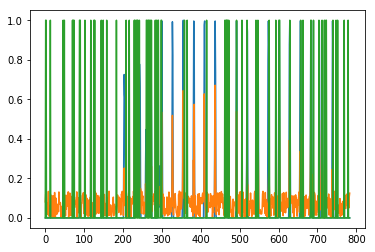

In [92]:
plt.plot(x_test)
plt.plot(x_noise)
print np.mean(x_test), np.mean(x_noise)
plt.plot(np.random.binomial(1,x_noise))

In [64]:
np.where(np.random.multinomial(1, np.ones(28)/28) == 1)[0][0]

23

In [119]:
lik_predictive

{0: {0: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16])},
  1: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16])},
  2: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16]),
   (0, 1): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16]),
   (1, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000